# Sentiment analysis


In [ ]:
import numpy as np
import pandas as pd
import os
import string
import tensorflow as tf
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from keras.models import Sequential, save_model, load_model
from keras.layers import Embedding, LSTM, Dense, Flatten, Bidirectional, Dropout
from keras.regularizers import l2, l1
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import datetime
import math
import re
import gensim
import gensim.downloader

## Read tripadvisor labeled data

In [ ]:
tripadvisor = pd.read_csv('https://github.com/paubernabe/data/blob/main/tripadvisor_hotel_reviews.csv?raw=true')

In [ ]:
tripadvisor_2 = pd.read_csv('https://github.com/paubernabe/data/blob/main/tripadvisor-positive.csv?raw=true')

In [ ]:
tripadvisor_neg = pd.read_csv('https://github.com/paubernabe/data/blob/main/tripadvisor-negative.csv?raw=true')

In [ ]:
tripadvisor

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [ ]:
tripadvisor = pd.concat([tripadvisor, tripadvisor_2, tripadvisor_neg], ignore_index=True)

In [ ]:
tripadvisor['Rating'].value_counts()

5.0    20608
4.0    12222
2.0    10161
1.0     8238
3.0     2184
Name: Rating, dtype: int64

In [ ]:
tripadvisor

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4.0
1,ok nothing special charge diamond member hilto...,2.0
2,nice rooms not 4* experience hotel monaco seat...,3.0
3,"unique, great stay, wonderful time hotel monac...",5.0
4,"great stay great stay, went seahawk game aweso...",5.0
...,...,...
53408,I have never seen such a messy hostel. my frie...,1.0
53409,"Peccato. La struttura è anche bella, posizione...",2.0
53410,Wir haben hier drei Nächte verbracht und waren...,1.0
53411,"Es mi primera mala puntuación, pero creo que s...",1.0


### Rating to Positive, Neutral or Negative


Decidim que les ressenyes que tinguin una puntuació igual o superior a 3, seran positives. Altrament, seran negatives.

In [ ]:
tripadvisor = tripadvisor.dropna()

def sentiment_by_rating(x):
  if type(x) == int or type(x) == float:
    if x == 1 or x == 2:
      return 0
    return 1

tripadvisor['sentiment'] = tripadvisor['Rating'].apply(sentiment_by_rating)

In [ ]:
tripadvisor

,Review,Rating,sentiment
0,nice hotel expensive parking got good deal sta...,4.0,1
1,ok nothing special charge diamond member hilto...,2.0,0
2,nice rooms not 4* experience hotel monaco seat...,3.0,1
3,"unique, great stay, wonderful time hotel monac...",5.0,1
4,"great stay great stay, went seahawk game aweso...",5.0,1
...,...,...,...
53408,I have never seen such a messy hostel. my frie...,1.0,0
53409,"Peccato. La struttura è anche bella, posizione...",2.0,0
53410,Wir haben hier drei Nächte verbracht und waren...,1.0,0
53411,"Es mi primera mala puntuación, pero creo que s...",1.0,0


### Neteja de caràcters especials i signes de puntuació del text

In [ ]:
def clean_text(x):

    if type(x) == str:
      
      x = re.sub('<.*?>', ' ', x)
      x = re.sub(r'\w*\d\w*', '', x)
      x = x.translate(str.maketrans(' ',' ',string.punctuation))
      x = re.sub("\n"," ",x)
      x = x.lower()
      
      if len(x) == 0 or x == '':
        return float('nan')
      
      t = ''
      for word in x.split():
          t += ' ' + word
      return t
    return float('nan')

tripadvisor['Review'] = tripadvisor['Review'].apply(clean_text)

In [ ]:
tripadvisor = tripadvisor.dropna()

In [ ]:
tripadvisor

,Review,Rating,sentiment
0,nice hotel expensive parking got good deal st...,4.0,1
1,ok nothing special charge diamond member hilt...,2.0,0
2,nice rooms not experience hotel monaco seattl...,3.0,1
3,unique great stay wonderful time hotel monaco...,5.0,1
4,great stay great stay went seahawk game aweso...,5.0,1
...,...,...,...
53408,i have never seen such a messy hostel my frie...,1.0,0
53409,peccato la struttura è anche bella posizione ...,2.0,0
53410,wir haben hier drei nächte verbracht und ware...,1.0,0
53411,es mi primera mala puntuación pero creo que s...,1.0,0


In [ ]:
def get_length_all_reviews(sentences):
    '''
    Returns a list of length of all reviews
    Used for plotting histogram
    '''
    lengths = [len(i.split(' ')) for i in sentences]
    return lengths

t_len = get_length_all_reviews(tripadvisor['Review'])

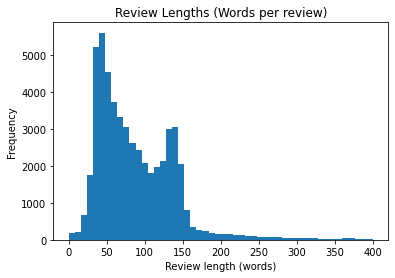

In [ ]:
def plot_histogram(sentence_lengths, x_dim):
    '''
    Plots histogram of length of all sentences
    '''
    plt.hist(sentence_lengths, 50, [0, x_dim])
    plt.xlabel('Review length (words)')
    plt.ylabel('Frequency')
    plt.title('Review Lengths (Words per review)')
    plt.show()

plot_histogram(t_len, 400)

### Divisió de les dades en train i test

In [ ]:
split = 0.8
X_train, X_test, y_train, y_test = train_test_split(tripadvisor['Review'],
                                                    tripadvisor['sentiment'],
                                                    test_size = split,
                                                    random_state = 42)

In [ ]:
documents = [_text.split() for _text in tripadvisor['Review']]

### Construcció del model Word2Vec

In [ ]:
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 30
W2V_MIN_COUNT = 4
W2V_MODEL = 0 #skipgram 1, cbow 0
SAMPLE=6e-5
ALPHA=0.03
MIN_ALPHA=1e-5

w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW,
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)

In [ ]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(125586513, 143579010)

In [ ]:
w2v_model.doesnt_match("bad nice good excellent".split())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'bad'

In [ ]:
w2v_model.similarity('perfecto', 'horrible')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.13513876

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tripadvisor['Review'])

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)


Total words 167324


### Construcció de la matriu de word embeddings

In [ ]:
def make_embedding_matrix(vec):

  embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
  for word, i in tokenizer.word_index.items():
    if word in vec:
      embedding_matrix[i] = vec[word]
  print(embedding_matrix.shape)
  return embedding_matrix

embedding_matrix = make_embedding_matrix(w2v_model.wv)


(167324, 300)


In [ ]:
SEQUENCE_LENGTH = 300

x_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=SEQUENCE_LENGTH)

### Creació de la xarxa neuronal

In [ ]:
def create_LSTM_model(vocab_length, in_length, opt = 'Adam',
                      learning_rate = 0.001):

   
    model = Sequential()
    model.add(Embedding(vocab_length, W2V_SIZE, weights=[embedding_matrix]))
    model.add(Bidirectional(LSTM(64,dropout=0.4, return_sequences=False, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
    model.add(Dense(32, activation='relu', kernel_regularizer='l2'))
    model.add(Dropout(0.4))
    model.add(Dense(2, activation='softmax'))

    optimizer = getattr(optimizers, opt)(learning_rate = learning_rate)
    model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    return model

LSTM_model = create_LSTM_model(vocab_size,
                               SEQUENCE_LENGTH,
                               opt = 'Adam',
                               learning_rate = 1e-4)
print(LSTM_model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 300)         50197200  
                                                                 
 bidirectional_8 (Bidirectio  (None, 128)              186880    
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 32)                4128      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 2)                 66        
                                                                 
Total params: 50,388,274
Trainable params: 50,388,274
Non-trainable params: 0
__________________________________________

In [ ]:
ep = 50

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

LSTM_history = LSTM_model.fit(x_train, y_train,
                              validation_data = (x_test, y_test),
                              batch_size = 128, epochs = ep, verbose = 1, callbacks = [es])

Epoch 1/50
84/84 [==============================] - 15s 135ms/step - loss: 8.5894 - accuracy: 0.5720 - val_loss: 7.8697 - val_accuracy: 0.6540
Epoch 2/50
84/84 [==============================] - 10s 125ms/step - loss: 7.3217 - accuracy: 0.6509 - val_loss: 6.7414 - val_accuracy: 0.6776
Epoch 3/50
84/84 [==============================] - 10s 126ms/step - loss: 6.2896 - accuracy: 0.6662 - val_loss: 5.8011 - val_accuracy: 0.6985
Epoch 4/50
84/84 [==============================] - 10s 126ms/step - loss: 5.4302 - accuracy: 0.6893 - val_loss: 5.0162 - val_accuracy: 0.7259
Epoch 5/50
84/84 [==============================] - 11s 126ms/step - loss: 4.7150 - accuracy: 0.7177 - val_loss: 4.3617 - val_accuracy: 0.7590
Epoch 6/50
84/84 [==============================] - 11s 126ms/step - loss: 4.1194 - accuracy: 0.7454 - val_loss: 3.8178 - val_accuracy: 0.7858
Epoch 7/50
84/84 [==============================] - 11s 127ms/step - loss: 3.6167 - accuracy: 0.7784 - val_loss: 3.3656 - val_accuracy: 0.8027

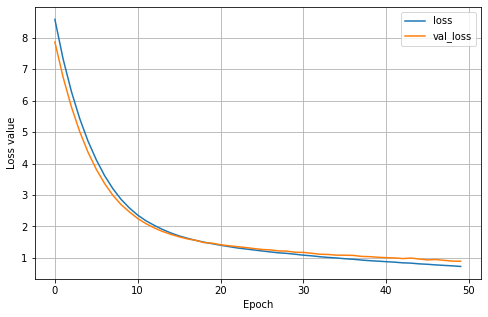

In [ ]:
pd.DataFrame(LSTM_history.history)[['loss','val_loss']].plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0.4, 0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

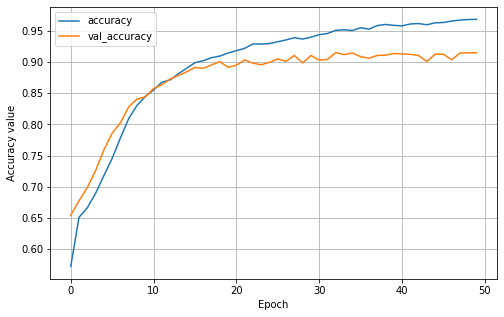

In [ ]:
pd.DataFrame(LSTM_history.history)[['accuracy','val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0.4, 0.8)
plt.xlabel('Epoch')
plt.ylabel('Accuracy value')
plt.show()

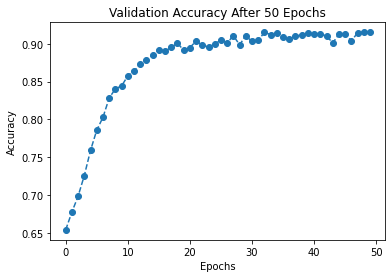

In [ ]:
plt.plot(LSTM_history.history['val_accuracy'], '--o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy After {} Epochs'.format(ep))
plt.show()

### Prova amb el conjunt de ressenyes etiquetades

In [ ]:
labeled = pd.read_csv('https://github.com/paubernabe/data/blob/main/labeled_airbnb.csv?raw=true')

In [ ]:
labeled

,Review,Sentiment
0,"Didn't see the ""luxury"" in this apartment duri...",0
1,"Very cozy apartment, with many large rooms, ve...",1
2,"All Perfect, just like in the pictures! Im sur...",1
3,Un apartamento muy agradable y adaptado para 6,1
4,Host is very helpful and easy to communicate w...,1
...,...,...
60,Eine sehr schöne Wohnung für 6 . geeignet,1
61,"Die Wohnung ist ziemlich ungemütlich, da sie s...",0
62,MEINE SCHLECHTESTE ERFAHRUNG MIT AIRBNB! ICH W...,0
63,Toller und freundlicher Gastgeber,1


In [ ]:
labeled.shape

(65, 2)

In [ ]:
labeled['Review'] = labeled['Review'].apply(clean_text)
labeled = labeled.dropna()

In [ ]:
SEQUENCE_LENGTH = 200

padded_labeled = pad_sequences(tokenizer.texts_to_sequences(labeled['Review']), maxlen=SEQUENCE_LENGTH)

In [ ]:
padded_labeled.shape

(65, 200)

In [ ]:
labeled_sentiments = LSTM_model.predict(padded_labeled)

### Visualització de la predicció del conjunt etiquetat

In [ ]:
pred = []
lab = []
for i in range(len(padded_labeled)):
  pred.append(np.argmax(labeled_sentiments[i]))
  lab.append(labeled.iloc[i]['Sentiment'])
  print(labeled_sentiments[i], np.argmax(labeled_sentiments[i]), labeled.iloc[i]['Sentiment'], labeled.iloc[i]['Review'])

[0.9717997  0.02820031] 0 0  didnt see the luxury in this apartment during our stay missing upon arrival coffee filters and coffee for the coffee maker laundry detergent and a lightbulb in the living room floor lamp too little toilet paper and paper towels provided for us was nearly out of tp by the night only a single bath towel was provided for each guest no face towel or wash cloth provided no extra towels at all the kitchens metal drying rack was rusty didnt want to place clean dishes on it the cooking pots and pans need to be replacedloose handle made using pot difficult scratched teflon made skillet unusable most beds had only a top sheet no summer duvet or blanket provided the doors leading to the patio were locked couldnt use the patio the patio does not look as it is pictured it was a mess with dead plants a discarded plastic bottle and cigarette butts one of the beds squeaked loudly at the slightest movement these issues were shared with horacio who was apologetic and provide

In [ ]:
from sklearn import metrics

acc = metrics.accuracy_score(pred, lab)
acc

0.9230769230769231

### Airbnb data reviews

In [ ]:
reviews = pd.read_csv('https://github.com/paubernabe/data/blob/main/reviews.csv.gz?raw=true', compression='gzip')

In [ ]:
#process the data as we did with the tripadvisor dataset

reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,18674,4808211,2013-05-27,4841196,Caron,"Great location. Clean, spacious flat. Would re..."
1,18674,10660311,2014-03-02,11600277,Juan Carlos,Mi mejor recomendación para este departamento....
2,18674,41087522,2015-08-04,35231385,Shlomi,"Big apartment, well equipped.\r<br/>Very good ..."
3,18674,81000756,2016-06-20,23223644,Joost,The Check in was fast and flexible. The price ...
4,18674,278588962,2018-06-18,4756672,Marius,Great location and enough space in the apartme...
...,...,...,...,...,...,...
541339,51856861,438136462860415266,2021-08-27,10825731,Cesar Eduardo,"Muy buen host, siemore atento y amable"
541340,51878702,440364869828843070,2021-08-30,100784279,Carrie,"This is a lovely room, the addition of a fridg..."
541341,51878702,441771410755550310,2021-09-01,191305109,Luciano,"excelente todo , la amabilidad de Lorenzo , la..."
541342,51878702,444706075446051095,2021-09-05,355496209,Győry,"Amazing place and host, the location was perfe..."


In [ ]:
reviews['comments'] = reviews['comments'].apply(clean_text)


In [ ]:
reviews.shape

(541344, 6)

In [ ]:
reviews = reviews.dropna()

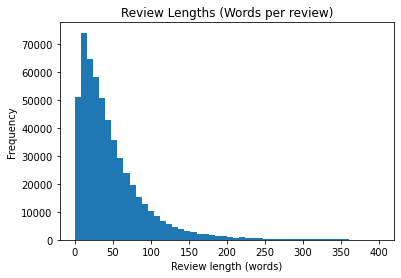

In [ ]:
rev_len = get_length_all_reviews(reviews['comments'])
plot_histogram(rev_len, 400)

In [ ]:
SEQUENCE_LENGTH = 200

padded_reviews = pad_sequences(tokenizer.texts_to_sequences(reviews['comments']), maxlen=SEQUENCE_LENGTH)


In [ ]:
padded_reviews.shape

(539847, 200)

In [ ]:
airbnb_sentiments = LSTM_model.predict(padded_reviews)

In [ ]:
ctr = 0
for i in range(0,50):
  if airbnb_sentiments[i][0] > airbnb_sentiments[i][1]:
    print(reviews.iloc[i]['listing_id'], airbnb_sentiments[i], reviews.iloc[i]['comments'])
    ctr+=1
print('----------------------')
print(ctr)

18674 [0.95102423 0.04897575]  the check in was fast and flexible the price is fair because the flat ist big enough for people if you are flexible as well we were the in a time where it wasnt so hot outside so i have no idea how hot it can get inside this was my second airbnb stay so i cant compare it so good with other apartments but i would wish me that the owner offers the guests more toilet paper etc because if it is a short stay you dont want to buy all the staff in big packages all in all we are very happy with this decision
18674 [0.708681   0.29131904]  our experience here was mixed the location of this flat is super close to la sagrada familia and there are lots of cute restaurants and cafes nearby the flat itself wad impersonal and not well represented by the photos the folks who rent this spot have a bunch of other places in the city so even though it was spacious it lacked charm and was heavily used without being heavily cleaned there were extra pillows but no extra pillow 

## Build sentiment analysis dataset with Airbnb Data

In [ ]:
'''from google.colab import drive
drive.mount('/content/drive')'''

Mounted at /content/drive


In [ ]:
#save model
#LSTM_model.save('/content/drive/MyDrive/TFG/Notebooks/saved_model/sa_model.h5')

In [ ]:
#import csv

In [ ]:
'''f = open('/content/drive/MyDrive/TFG/data/sentiment_analysis2.csv', 'w')

writer = csv.writer(f)

writer.writerow(['id','Review','Sentiment'])'''

21

In [ ]:
'''AUTOMATED_POSTING = 'automated posting'
for i in range(len(airbnb_sentiments)):
  if AUTOMATED_POSTING not in reviews.iloc[i]['comments']:
    writer.writerow([reviews.iloc[i]['listing_id'],reviews.iloc[i]['comments'], np.argmax(airbnb_sentiments[i])])
f.close()'''

In [ ]:
#sa_data = pd.read_csv('/content/drive/MyDrive/TFG/data/sentiment_analysis2.csv')

In [ ]:
#sa_data.head()

,id,Review,Sentiment
0,18674,great location clean spacious flat would reco...,1
1,18674,mi mejor recomendación para este departamento...,1
2,18674,big apartment well equipped very good service...,1
3,18674,the check in was fast and flexible the price ...,0
4,18674,great location and enough space in the apartm...,1


In [ ]:
#sa_data['Sentiment'].value_counts()

1    512415
0     23886
Name: Sentiment, dtype: int64